# Metodología TRIAGE

El triage es un proceso creado por el Observatorio de Desarrollo Económico de Bogotá (ODEB) para optimizar las convocatorias de la oferta institucional de la Secretaría Distrital de Desarrollo Económico (SDDE) y facilitar su evaluación. Para esto, el triage utiliza una base única de unidades productivas de Bogotá y estima un puntaje que organiza las unidades productivas de acuerdo con la posibilidad que estas tienen de beneficiarse del programa. Primero, utiliza el análisis de factores para datos mixtos, una variante de la metodología de componentes principales, para reducir la dimensionalidad de los criterios de los programas que deben cumplir las unidades productivas participantes, posteriormente, agrupa las unidades productivas de acuerdo a esta caracterización simplificada usando la técnica k-means y, por último, genera un puntaje de priorización de acuerdo a la distancia de la unidad productiva al centroide del grupo preferido para recibir el programa. 


### Definir las rutas de las carpetas

In [1]:
# Se importa la librería para cambiar WD
import os
print(os.getcwd()) # Ver WD antes

# Rutas a las carpetas
root = '/Users/jennyriveraburgos/Library/CloudStorage/GoogleDrive-jrivera.desarrolloeconomico@gmail.com/My Drive/Notebook_Jupyter_TRIAGE/'
code_path = root + os.sep + '0_Code' + os.sep
raw_path = root + os.sep + '1_Raw' + os.sep
temp_path = root + os.sep + '2_Temp' + os.sep
clean_path = root + os.sep + '3_Clean' + os.sep
output_path = root + os.sep + '4_Output' + os.sep

os.chdir(code_path) # Cambia el WD a 0_Code
print(os.getcwd()) # Ver WD después

/Users/jennyriveraburgos/Library/CloudStorage/GoogleDrive-jrivera.desarrolloeconomico@gmail.com/My Drive/Notebook_Jupyter_TRIAGE/0_Code
/Users/jennyriveraburgos/Library/CloudStorage/GoogleDrive-jrivera.desarrolloeconomico@gmail.com/My Drive/Notebook_Jupyter_TRIAGE/0_Code


### Cargar librerías

In [2]:
#Código necesario para instalar librerías
#pip install fontstyle
#pip install prince


# Se importan las librerías externas a usar
import numpy as np
np.random.seed(0)

import pandas as pd
import fontstyle
import matplotlib.pyplot as plt
from prince import FAMD
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn import linear_model
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.impute import SimpleImputer
import re
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf

from IPython.display import Markdown as md


# Se importan los scripts propios a usar
import limpieza_variables as lv
import criterios_programas as cp
import diccionario_variables as dv
import Fun_triage as triage

### Abrir base de Tropa

Se utilizan solo los datos de las unidades productivas que autorizaron el uso de sus datos.

In [3]:
#file_tropa = '20220919 Datos Tropa v1+v2.csv'
#file_tropa = 'Base priorización hasta 21 oct 22.xlsx'
file_tropa = 'df_tropa_muestra.xlsx'


if file_tropa[-5:] == '.xlsx':
    df_tropa = pd.read_excel(raw_path + file_tropa)
else:
    df_tropa = pd.read_csv(raw_path + file_tropa, low_memory=False, sep=',')

n_tropa_total = len(df_tropa)

df_tropa = df_tropa[df_tropa['AUTORIZACION'] == "Si"]
n_tropa_autorizado = len(df_tropa)

In [4]:
md(f"La base de tropa cuenta con un total de {n_tropa_total}. Al dejar sólo las observaciones autorizadas se tienen {n_tropa_autorizado} unidades productivas" )

La base de tropa cuenta con un total de 26420. Al dejar sólo las observaciones autorizadas se tienen 26420 unidades productivas

### Preparación de variables

Según la variable se hace distintos procesos de limpieza:
1. ANTIGUEDAD: se unifica la forma de escribir las respuesta utilizando el diccionario dict_antiguedad
2. CONTABILIDAD: se unifica la forma de escribir las respuesta utilizando el diccionario dict_contabilidad
3. EDAD: se registra como null los valores de edad menores a 18 y mayores a 99, suponiendo que los que no se encuentren dentro de estos límites son errores de digitación por parte del encuestador
4. INGRESOS: se registran los valores de ingresos mayores a 1.000.000 y menores a 9.000.000. Se truncan los valores en 9.000.000, donde todo registro mayor a 9.000.000 se registra como 9.000.000. Los valores menores a 1.000.000 se registran como null suponiendo que son errores de digitación por parte del encuestador
5. NO_TRABAJADORES: se registran el número de trabajadores mayor a 0 y menor a 10. Se truncan los valores en 10, donde todo registro mayor a 10 se registra como 10. Los valores menores a 0 se registran como null suponiendo que son errores de digitación por parte del encuestador.
6. NO_TRABAJADORES-MAYOR: se crea una variable tipo dummy que toma el valor de 0 si la empresa tiene menos de 10 trabajadores y 1 si tiene 10 o más
7. ANTIGUEDAD_MAYOR_UN_AÑO: se crea una variable tipo dummy que toma el valor de 1 si la empresa tiene más de un año de antigüedad, y 0 en caso contrario
8. ANTIGUEDAD_MAYOR_TRES_AÑOS: se crea una variable tipo dummy que toma el valor de 1 si la empresa tiene más de tres años de antigüedad, y 0 en caso contrario
9. CORAZON_PRODUCTIVO: se crea una variable tipo dummy que toma el valor de 1 si la empresa esta ubicada en alguno de los corazones productivos priorizados para 2022, y 0 en caso contrario
10. PROPIETARIOS_MUJERES_dummy: se crea una variable tipo dummy que toma el valor de 1 si la empresa tiene alguna propietaria mujer, y 0 en caso contrario
11. PROPIETARIOS_HOMBRES_dummy: se crea una variable tipo dummy que toma el valor de 1 si la empresa tiene algun propietario hombre, y 0 en caso contrario
12. Para la variables METAS -  siendo esta una pregunta de opción múltiple - crea una columna para cada una de las opciones de METAS posible. Cada columna es de tipo dummy, donde 1 significa que el encuestado considera esa como una meta para crear empresa
13. CIIU_DOS_DIGITOS: se extraen los dos primeros dígitos de la columna ACTIVIDAD_ECONOMICA la cual contiene el CIIU de 4 dígitos.
14. CIIU_DOS_DIGITOS_CATEGORIA: se categorizan la variable CIIU_DOS_DIGITOS según la categoría económica a la que se dedican las empresas

In [5]:
df_tropa['ANTIGUEDAD'] = df_tropa['ANTIGUEDAD'].replace(dv.dict_antiguedad)
df_tropa['CONTABILIDAD'] = df_tropa['CONTABILIDAD'].replace(dv.dict_contabilidad)

df_tropa['EDAD'] = list(map(lambda h: lv.limpieza_edad(h), df_tropa['EDAD']))
df_tropa['INGRESOS'] = list(map(lambda h: lv.limpieza_ingresos(h), df_tropa['INGRESOS']))
df_tropa['NO_TRABAJADORES_MAYOR_9'] = list(map(lambda h: lv.limpieza_num_trabajadores_mayor(h), df_tropa['NO_TRABAJADORES']))
df_tropa['NO_TRABAJADORES'] = list(map(lambda h: lv.limpieza_num_trabajadores(h), df_tropa['NO_TRABAJADORES']))
df_tropa['ANTIGUEDAD_MAYOR_UN_AÑO'] = list(map(lambda h: lv.limpieza_antiguedad_mayor(h), df_tropa['ANTIGUEDAD']))
df_tropa['ANTIGUEDAD_MAYOR_TRES_AÑOS'] = list(map(lambda h: lv.limpieza_antiguedad_mayor_2years(h), df_tropa['ANTIGUEDAD']))
df_tropa['CORAZON_PRODUCTIVO'] = list(map(lambda h: lv.corazon_productivo(h), df_tropa['UPZ']))
df_tropa['PROPIETARIOS_MUJERES_dummy'] = list(map(lambda h: lv.dummy_propietario(h), df_tropa['PROPIETARIOS_MUJERES']))
df_tropa['PROPIETARIOS_HOMBRES_dummy'] = list(map(lambda h: lv.dummy_propietario(h), df_tropa['PROPIETARIOS_HOMBRES']))


df_tropa = lv.crear_nuevas_columnas(df_tropa, 'METAS') #Crear columnas para cada una de las opciones de METAS
df_tropa['ACTIVIDAD_ECONOMICA'] = df_tropa['ACTIVIDAD_ECONOMICA'].map(lambda x: re.sub(r'\W+', '', x))
df_tropa['CIIU_DOS_DIGITOS'] = lv.obtener_primeros_digitos(df_tropa, 'ACTIVIDAD_ECONOMICA',  2)  #Obtener primeros digitos de CIIU
df_tropa['CIIU_DOS_DIGITOS'] = pd.to_numeric(df_tropa['CIIU_DOS_DIGITOS'], errors='coerce')
df_tropa['CIIU_DOS_DIGITOS_CATEGORIA'] = list(map(lambda h: lv.categorize_ciiu(h), df_tropa['CIIU_DOS_DIGITOS']))

### Selección de variables y programas a priorizar

Las siguientes listas y diccionarios definen los criterios utilizados en el proceso de priorización. 

    1. col_contacto: presenta las variables necesarias para la identificación y contacto de las unidades productivas
    2. list_programa: es una lista que enumera los programas para los cuales se va a realizar la priorización
    3. criterios_dict: es un diccionario que contiene los criterios que se priorizan para cada uno de los programas. Estos criterios se definen en conjunto con las áreas de la Secretaría encargadas de la implementación. Este diccionario se encuentra en criterios_programas.py
    4. tipo_dict: establece si los criterios son excluyentes o no. Existen algunos programas que por su misma naturaleza solo atienden unidades productivas que cumplen todos los criterios de priorización. En cambio hay otros que solicitan el cumplimiento de al menos uno de los criterios Este diccionario se encuentra en criterios_programas.py

In [6]:
col_contacto = ['ObjectID', 'LOCALIDAD', 'UPZ', 'DIRECCION_COMPLETA', 'COMPLEMENTO',
                'NOMBRE_ENCUESTADO', 'RAZON_SOCIAL', 'NOMBRE_COMERCIAL', 'TELEFONOS', 'CORREOS', 'NOMBRE_PROPIETARIO',
                'NUMERO_ID_PROPIETARIO', 'TIPO_ID_NEGOCIO','NUMERO_ID_NEGOCIO']
df_tropa_contacto = df_tropa.loc[:, col_contacto]

# %% Elección de programa
list_programas = ['Agencia Pública de Empleo', 
                  'Pago por resultados o Empleo Joven', 
                  'Bogotá Productiva Local',
                  'Camino a la inclusión financiera',  
                  'Corazon Productivo', 
                  'Bogotá Alto Impacto',  
                  'Hecho en Bogotá']


### Función Triage

A continuación se explican algunas funciones y sus criterios contenidos en la función triage

#### Imputación de datos utilizando MICE
Algunos registros pueden tener valores faltantes, sea por negación al contestar por parte del encuestado o por errores de registros del encuestador. Dado lo anterior, y ante la incoveniencia de eliminar registros con algunas variables faltantes para no dejar por fuera a unidades productivas de los programas, se opta por recurrir a estrategias de imputación. 

Para la imputación de variables continuas se utiliza el método de Imputaciones Múltiples por Ecuaciones Encadenadas, conocido como MICE por sus siglas en inglés. Este es un método de imputación iterativo el cual imputa valores faltantes para cada columna utilizando una regresión bayesiana lineal y como variables independientes todas las demás columnas. Este proceso lo realiza manera iterativa hasta minimizar la diferencia en valores de una iteración a otra. 

A continuación se define los criterios del modelo.
    1. Como ecuación para estimación se utiliza una regresión bayesiana lineal
    2. En la primera iteración se utiliza la media de las variables para la regresión
    3. Se imputa primero tomando las variables con menor cantidad de valores faltantes como variable dependiente. 

In [7]:
# %% Mice imputer
mice_imputer = sklearn.impute.IterativeImputer(
    estimator=linear_model.BayesianRidge(),
    initial_strategy='mean',
    imputation_order='ascending', 
    random_state=42
    )

#### Reducción de dimensiones utilizando FAMD

Para reducir la dimensionalidad tanto de variables continuas como categóricas se utiliza el análisis de factores para datos mixtos (FAMD en inglés). Al igual que el PCA, este análisis parte del principio de que existen unos componentes que condensan la varianza de múltiples variables. A diferencia del PCA, el FAMD tiene en cuenta la varianza tanto de variables continuas como categóricas.



In [8]:
# %% FAMD: reducción de dimensiones
famd = FAMD(n_components=2, 
            n_iter=3, 
            copy=True, 
            check_input=True,
            engine='auto', 
            random_state=0)

#### Clusterización utilizando K-means

K-means es una de las metodologías más usadas para hallar clústeres o cúmulos de datos y su uso es tan extendido porque esos grupos tienen la característica de que sus miembros son lo más parecido posible entre sí y lo más disímiles de los demás. El algoritmo comienza con una agrupación aleatoria de las observaciones en un número de agrupaciones preestablecido y minimiza las distancias de cada observación a su centroide, mientras maximiza la distancia entre los centroides. El algoritmo recursivamente reagrupa las observaciones hasta que encuentra los centroides y grupos óptimos (centroides), así, una observación cualquiera pertenece a un grupo porque está más cerca del centroide que lo representa.

<img src="Kmeans.png" width="400" height="200">


#### Paso a paso

Para cada uno de los programas se realizan los siguientes pasos:
    
   1. Se define si el programa tiene criterios excluyentes o no y se filtra según corresponda
   2. Se imputan los valores faltantes utilizando el método MICE
   3. Se utiliza el FAMD para reducir la dimensión de las variables
   4. Se utiliza el método Elbow para definir el número de clusters.
   5. Se utiliza los k vecinos más próximos (KNN) para definir categorizar cada unidad productiva en un cluster.
   6. Se escoge un cluster a priorizar según las características de las unidades productivas. Por ejemplo, el cluster con menor promedio de ingresos y mayor porcentaje de mujeres propietarios.
   7. Se le asigna un puntaje a cada unidad productiva según la distancia a la que se encuentra del centroide del cluster priorizado.
    

Para reducir la dimensionalidad tanto de variables continuas como categóricas se utiliza el análisis de factores para datos mixtos (FAMD en inglés). Al igual que el PCA, este análisis parte del principio de que existen unos componentes que condensan la varianza de múltiples variables. A diferencia del PCA, el FAMD tiene en cuenta la varianza tanto de variables continuas como categóricas. 

Programa: Agencia Pública de Empleo
     1. Tipo de criterio: No excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,3014.000000,3.014000e+03,3014.000000,3014.000000,3014.000000
mean,42.972669,2.576009e+07,5.529373,0.457532,0.563703
std,11.980597,5.696138e+07,23.170966,0.498276,0.496008
min,19.000000,1.100000e+06,1.000000,0.000000,0.000000
25%,34.000000,1.200000e+07,2.000000,0.000000,0.000000
50%,42.913197,2.576009e+07,3.000000,0.000000,1.000000
75%,51.000000,2.576009e+07,5.000000,1.000000,1.000000
max,96.000000,1.850000e+09,1000.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
df_famd


FAMD(random_state=0)

prueba x


77640905714.52493

prueba rc


,0,1
18,1.275154,0.201551
20,1.385935,0.888957
21,-1.446966,-0.551824
22,0.952093,-0.027449
36,-1.420050,-1.207355
...,...,...
26392,0.459481,-1.116425
26395,0.992392,0.369253
26397,0.943604,-0.128138
26403,1.130483,0.059820


Distorsión
1 : 1.2627236678698246
2 : 0.7061364888530229
3 : 0.5756666546193935
4 : 0.4745190231781464
5 : 0.4576959283853009
6 : 0.3949890338937185
7 : 0.34415719447651794
8 : 0.33703552906067036
9 : 0.30595304214920804


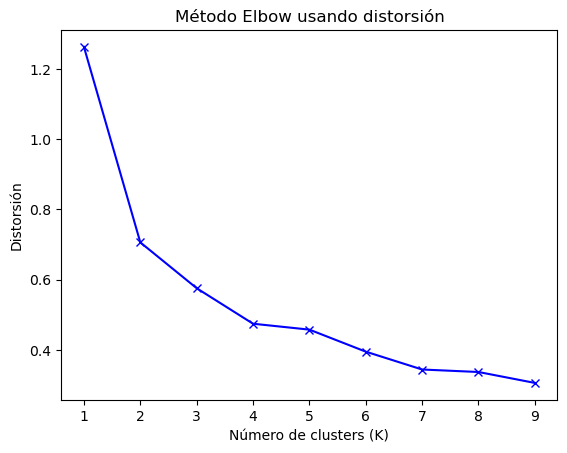

     5. Clusterización utilizando KMeans


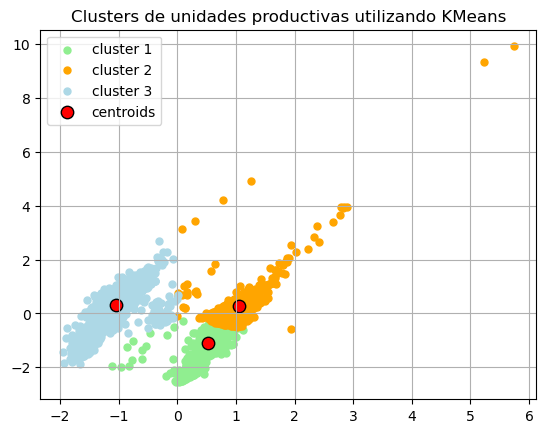

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan
kmeans,,,,,,,,,,,,,,,,,,,,,
1,1023,1023,1023,1023,1023,1023,1023,1023,1023,1023,...,1023,1023,1023,1023,1023,1023,1023,1023,1023,1023
2,1352,1352,1352,1352,1352,1352,1352,1352,1352,1352,...,1352,1352,1352,1352,1352,1352,1352,1352,1352,1352
0,639,639,639,639,639,639,639,639,639,639,...,639,639,639,639,639,639,639,639,639,639


kmeans                                                                0  \
index                                              mean    13096.785603   
                                                   median  13284.000000   
                                                   std      7812.520466   
EDAD                                               mean       38.757227   
                                                   median     38.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.117932   
RAZON_CREAR_NEGOCIO_nan                            mean        0.004695   
                                                   median      0.000000   
                                                   std         0.068411   

kmeans                                                                1  \
index                                              mean    13105.891496   
                                                   median  13198.000000   
                                                   std      7628.414956   
EDAD                                               mean       46.876726   
                                                   median     45.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.076396   
RAZON_CREAR_NEGOCIO_nan                            mean        0.001955   
                                                   median      0.000000   
                                                   std         0.044194   

kmeans                                                                2  
index                                              mean    13239.487426  
                                                   median  13119.000000  
                                                   std      7794.797456  
EDAD                                               mean       42.010996  
                                                   median     42.000000  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000  
                                                   std         0.114656  
RAZON_CREAR_NEGOCIO_nan                            mean        0.003698  
                                                   median      0.000000  
                                                   std         0.060723  

[120 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Agencia Pública de Empleo
index,,,,,,,,,,,,,,,,,,,,,
18,62.0000,4.000000e+06,3.0,No,10 años o más,0,1,Si y la renovó el último año,Me_gusta_este_producto_o_servic,1,...,0,0,0,0,0,0.528476,-1.09862,1.499324,87.914489,87.914489
20,52.0000,2.576009e+07,20.0,Si,10 años o más,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,0.528476,-1.09862,2.164647,82.434692,82.434692
22,55.0000,2.576009e+07,3.0,Si,Menos de un año,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,0.528476,-1.09862,1.151893,90.776033,90.776033
63,42.9806,2.576009e+07,6.0,Si,10 años o más,0,1,Si y la renovó el último año,Necesita_generar_ingresos_adici,1,...,0,0,0,0,0,0.528476,-1.09862,1.626038,86.870833,86.870833
77,25.0000,2.576009e+07,3.0,Si,De 5 a menos de 10 años,0,1,"Sí, pero desactualizada",Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,0.528476,-1.09862,0.784921,93.798523,93.798523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26272,33.0000,2.576009e+07,4.0,No,Menos de un año,0,1,Si y la renovó el último año,Necesita_generar_ingresos_adici,0,...,0,0,0,0,0,0.528476,-1.09862,0.031976,100.000000,100.000000
26324,23.0000,2.576009e+07,1.0,No,Menos de un año,0,1,Si y la renovó el último año,Necesita_generar_ingresos_adici,0,...,0,0,0,0,0,0.528476,-1.09862,0.215770,98.486218,98.486218
26332,59.0000,7.000000e+06,3.0,No,De 3 a menos de 5 años,0,1,"Sí, pero desactualizada",Identificó una oportunidad en e,0,...,0,0,0,0,0,0.528476,-1.09862,0.281311,97.946404,97.946404


Programa: Pago por resultados o Empleo Joven
     1. Tipo de criterio: No excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,1832.000000,1.832000e+03,1832.000000,1832.000000,1832.000000
mean,42.813947,2.721994e+07,5.350437,0.454694,0.568231
std,12.050817,6.339417e+07,15.956539,0.498079,0.495458
min,19.000000,1.100000e+06,1.000000,0.000000,0.000000
25%,34.000000,1.200000e+07,2.000000,0.000000,0.000000
50%,42.640291,2.721994e+07,3.000000,0.000000,1.000000
75%,51.000000,2.721994e+07,4.000000,1.000000,1.000000
max,89.000000,1.850000e+09,378.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
df_famd


FAMD(random_state=0)

prueba x


49866933808.688644

prueba rc


,0,1
22,0.993526,-0.129491
36,-1.351424,-0.878573
41,-0.485246,-0.117741
42,-1.297078,-0.097547
44,-1.145878,0.174899
...,...,...
26347,-1.535432,-0.670499
26376,0.748068,-0.525919
26392,0.474686,-1.106769
26397,0.835779,-0.318249


Distorsión
1 : 1.2443910437096124
2 : 0.6619947933871392
3 : 0.5491737047977862
4 : 0.5061330276601977
5 : 0.4228655065251885
6 : 0.4130999572124277
7 : 0.357039009182359
8 : 0.31488897441636576
9 : 0.28453109793615394


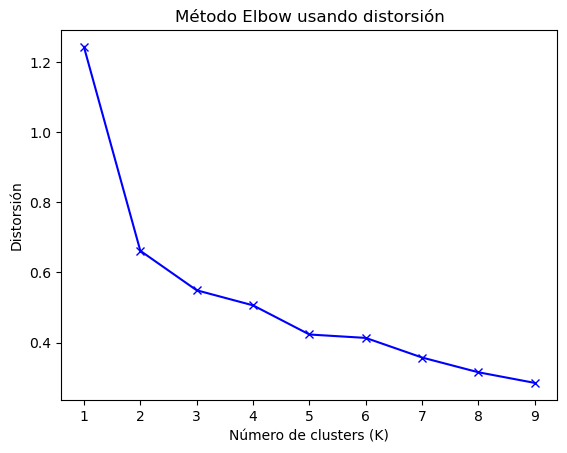

     5. Clusterización utilizando KMeans


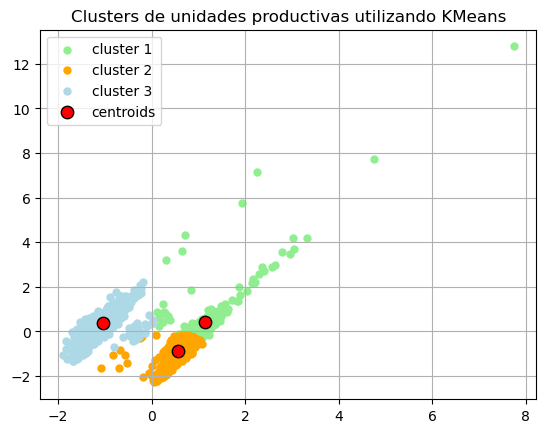

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,RAZON_CREAR_NEGOCIO_Las_personas_necesitan_de_mis_p,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan
kmeans,,,,,,,,,,,,,,,,,,,,,
0,454,454,454,454,454,454,454,454,454,454,...,454,454,454,454,454,454,454,454,454,454
2,808,808,808,808,808,808,808,808,808,808,...,808,808,808,808,808,808,808,808,808,808
1,570,570,570,570,570,570,570,570,570,570,...,570,570,570,570,570,570,570,570,570,570


kmeans                                                                0  \
index                                              mean    13140.455947   
                                                   median  13186.000000   
                                                   std      7546.081254   
EDAD                                               mean       48.529680   
                                                   median     48.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.081110   
RAZON_CREAR_NEGOCIO_nan                            mean        0.002203   
                                                   median      0.000000   
                                                   std         0.046932   

kmeans                                                                1  \
index                                              mean    12764.010526   
                                                   median  12722.500000   
                                                   std      7754.853506   
EDAD                                               mean       39.188508   
                                                   median     38.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.093329   
RAZON_CREAR_NEGOCIO_nan                            mean        0.000000   
                                                   median      0.000000   
                                                   std         0.000000   

kmeans                                                                2  
index                                              mean    13156.737624  
                                                   median  13268.500000  
                                                   std      7874.394858  
EDAD                                               mean       42.159933  
                                                   median     42.000000  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000  
                                                   std         0.105015  
RAZON_CREAR_NEGOCIO_nan                            mean        0.002475  
                                                   median      0.000000  
                                                   std         0.049721  

[114 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Pago por resultados o Empleo Joven
index,,,,,,,,,,,,,,,,,,,,,
22,55.000000,2.721994e+07,3.0,Si,Menos de un año,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,0,0,0,0,0,0.561084,-0.871612,0.858923,94.473344,94.473344
63,42.839875,2.721994e+07,6.0,Si,10 años o más,0,1,Si y la renovó el último año,Necesita_generar_ingresos_adici,0,...,0,0,0,0,0,0.561084,-0.871612,1.337167,91.371243,91.371243
157,64.000000,2.721994e+07,3.0,No,10 años o más,0,1,Si y la renovó el último año,Me_gusta_este_producto_o_servic,0,...,0,0,0,0,0,0.561084,-0.871612,1.212254,92.181482,92.181482
186,28.000000,2.721994e+07,10.0,Si,De 5 a menos de 10 años,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,0,0,0,0,0,0.561084,-0.871612,1.149990,92.585352,92.585352
197,89.000000,1.400000e+07,2.0,No,10 años o más,0,0,Si y la renovó el último año,Me gusta este producto o servic,0,...,0,0,0,0,0,0.561084,-0.871612,1.647352,89.359240,89.359240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26272,33.000000,2.721994e+07,4.0,No,Menos de un año,0,1,Si y la renovó el último año,Necesita_generar_ingresos_adici,1,...,0,0,0,0,0,0.561084,-0.871612,0.151265,99.063531,99.063531
26332,59.000000,7.000000e+06,3.0,No,De 3 a menos de 5 años,0,1,"Sí, pero desactualizada",Identificó una oportunidad en e,1,...,0,0,0,0,0,0.561084,-0.871612,0.182812,98.858901,98.858901
26376,35.000000,1.000000e+07,4.0,Si,10 años o más,0,1,"Sí, pero desactualizada",No tenía trabajo,1,...,1,0,0,0,0,0.561084,-0.871612,0.393022,97.495387,97.495387


Programa: Bogotá Productiva Local
     1. Tipo de criterio: Excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,20228.000000,2.022800e+04,20228.000000,20228.000000,20228.000000
mean,46.299856,9.908204e+06,2.387928,0.473205,0.548497
std,12.673853,1.995300e+07,1.590234,0.499294,0.497655
min,19.000000,1.014000e+06,1.000000,0.000000,0.000000
25%,37.000000,6.000000e+06,1.000000,0.000000,0.000000
50%,46.000000,9.908204e+06,2.000000,0.000000,1.000000
75%,55.000000,9.908204e+06,3.000000,1.000000,1.000000
max,98.000000,1.700000e+09,9.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
df_famd


FAMD(random_state=0)

prueba x


200423148979.72656

prueba rc


,0,1
0,-1.011100,0.661132
2,-1.129517,-0.126958
3,-1.238778,-0.183841
4,0.548412,-0.637990
6,-0.811087,1.279329
...,...,...
26415,0.858567,2.088462
26416,-1.391237,0.209007
26417,1.242493,0.847440
26418,-0.607629,1.028764


Distorsión
1 : 1.2967508585257372
2 : 0.7807190258173623
3 : 0.63338162856507
4 : 0.515665632110435
5 : 0.4477655928266971
6 : 0.39169005953208064
7 : 0.36028023083092015
8 : 0.33352314411529493
9 : 0.31268583500661484


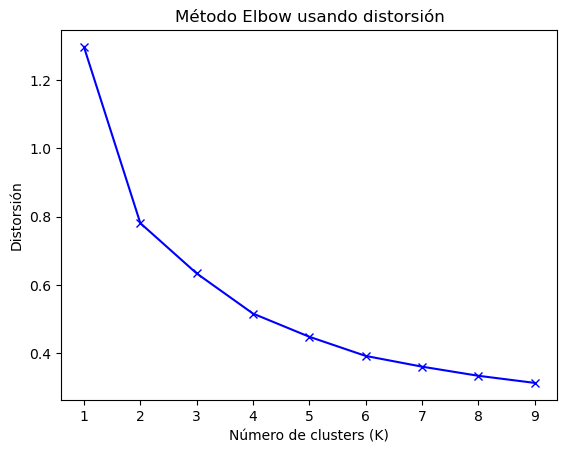

     5. Clusterización utilizando KMeans


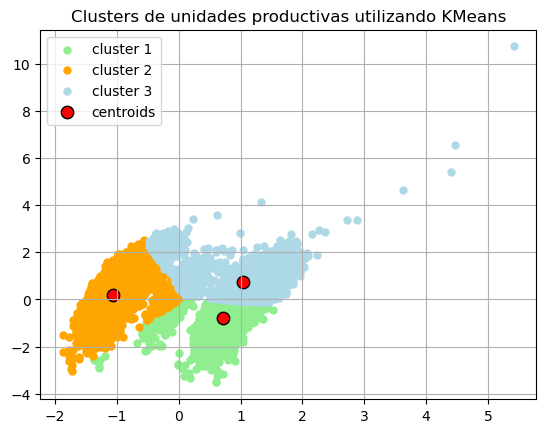

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan
kmeans,,,,,,,,,,,,,,,,,,,,,
1,9080,9080,9080,9080,9080,9080,9080,9080,9080,9080,...,9080,9080,9080,9080,9080,9080,9080,9080,9080,9080
0,6401,6401,6401,6401,6401,6401,6401,6401,6401,6401,...,6401,6401,6401,6401,6401,6401,6401,6401,6401,6401
2,4747,4747,4747,4747,4747,4747,4747,4747,4747,4747,...,4747,4747,4747,4747,4747,4747,4747,4747,4747,4747


kmeans                                                                0  \
index                                              mean    13165.747539   
                                                   median  13053.000000   
                                                   std      7578.134073   
EDAD                                               mean       51.224897   
                                                   median     51.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.129388   
RAZON_CREAR_NEGOCIO_nan                            mean        0.001250   
                                                   median      0.000000   
                                                   std         0.035333   

kmeans                                                                1  \
index                                              mean    13242.093062   
                                                   median  13287.500000   
                                                   std      7626.140723   
EDAD                                               mean       45.719005   
                                                   median     45.858246   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.123217   
RAZON_CREAR_NEGOCIO_nan                            mean        0.002313   
                                                   median      0.000000   
                                                   std         0.048038   

kmeans                                                                2  
index                                              mean    13436.502001  
                                                   median  13431.000000  
                                                   std      7599.055781  
EDAD                                               mean       40.769825  
                                                   median     40.000000  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000  
                                                   std         0.090277  
RAZON_CREAR_NEGOCIO_nan                            mean        0.001053  
                                                   median      0.000000  
                                                   std         0.032441  

[117 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Bogotá Productiva Local
index,,,,,,,,,,,,,,,,,,,,,
0,33.0,9.908204e+06,2.0,No,De 1 a menos de 3 años,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,0.718851,-0.80344,2.266650,81.842091,81.842091
2,62.0,6.000000e+06,2.0,No,De 5 a menos de 10 años,1,0,Si y la renovó el último año,Identificó una oportunidad en e,1,...,0,0,0,0,0,0.718851,-0.80344,1.968271,84.240149,84.240149
3,54.0,9.908204e+06,2.0,No,De 3 a menos de 5 años,1,0,Si y la renovó el último año,No_tenía_trabajo,1,...,1,0,0,0,0,0.718851,-0.80344,2.053342,83.556439,83.556439
6,45.0,2.500000e+06,2.0,Si,De 1 a menos de 3 años,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,0.718851,-0.80344,2.584307,79.289099,79.289099
9,50.0,1.200000e+06,1.0,No,De 3 a menos de 5 años,1,0,Si y la renovó el último año,No_tenía_trabajo,1,...,1,0,0,0,0,0.718851,-0.80344,2.142185,82.842410,82.842410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26405,41.0,9.908204e+06,1.0,Si,De 3 a menos de 5 años,0,1,"Sí, pero desactualizada",Identificó_una_oportunidad_en_e,2,...,0,0,0,0,0,0.718851,-0.80344,1.214096,90.301422,90.301422
26407,59.0,9.908204e+06,7.0,No,10 años o más,0,1,Si y la renovó el último año,Me_gusta_este_producto_o_servic,2,...,0,0,0,0,0,0.718851,-0.80344,1.110924,91.130605,91.130605
26415,37.0,9.908204e+06,9.0,Si,10 años o más,1,1,Si y la renovó el último año,Identificó una oportunidad en e,2,...,0,0,0,0,0,0.718851,-0.80344,2.895276,76.789855,76.789855


Programa: Camino a la inclusión financiera
     1. Tipo de criterio: No excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,8980.000000,8.980000e+03,8980.000000,8980.000000,8980.000000
mean,46.467055,9.165035e+06,2.344353,0.508463,0.548552
std,13.613539,2.404168e+07,5.879774,0.499956,0.497665
min,-5.437207,1.000008e+06,1.000000,0.000000,0.000000
25%,36.000000,4.000000e+06,1.000000,0.000000,0.000000
50%,46.441106,9.165035e+06,2.000000,1.000000,1.000000
75%,56.000000,9.165035e+06,2.000000,1.000000,1.000000
max,96.000000,1.700000e+09,380.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
df_famd


FAMD(random_state=0)

prueba x


82302016058.13622

prueba rc


,0,1
5,-1.283505,1.240320
7,-0.825586,-0.763256
10,0.987655,0.624552
15,-0.696750,-0.445025
23,0.960515,-0.791752
...,...,...
26409,1.168236,-0.824475
26410,-0.824620,-1.467883
26412,-0.174959,1.075966
26415,-0.025417,1.761374


Distorsión
1 : 1.2766881618219963
2 : 0.7669245496030873
3 : 0.627883863647092
4 : 0.5070294176901223
5 : 0.4504027997132923
6 : 0.402054874954646
7 : 0.39886040994566696
8 : 0.3629244247449705
9 : 0.3361073456716245


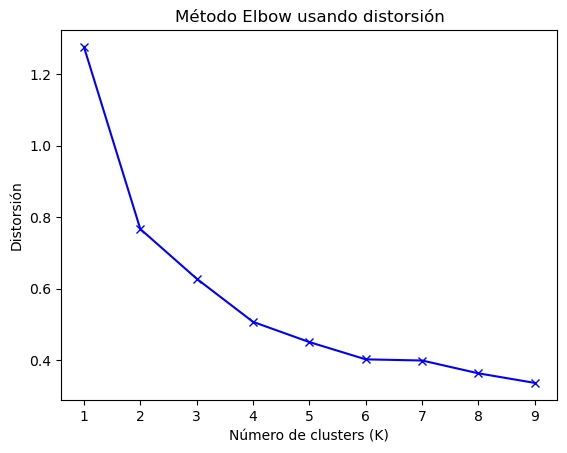

     5. Clusterización utilizando KMeans


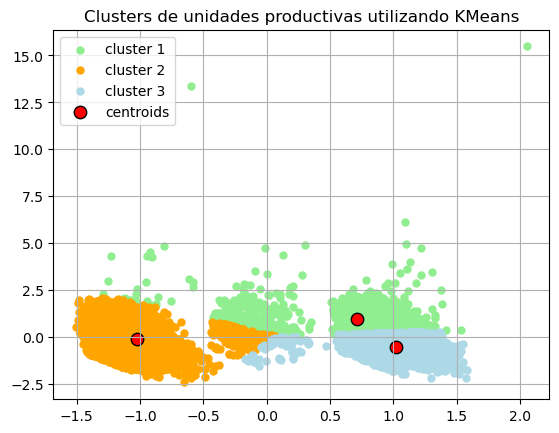

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan
kmeans,,,,,,,,,,,,,,,,,,,,,
1,4168,4168,4168,4168,4168,4168,4168,4168,4168,4168,...,4168,4168,4168,4168,4168,4168,4168,4168,4168,4168
0,2034,2034,2034,2034,2034,2034,2034,2034,2034,2034,...,2034,2034,2034,2034,2034,2034,2034,2034,2034,2034
2,2778,2778,2778,2778,2778,2778,2778,2778,2778,2778,...,2778,2778,2778,2778,2778,2778,2778,2778,2778,2778


kmeans                                                                0  \
index                                              mean    13307.499017   
                                                   median  13131.000000   
                                                   std      7563.055737   
EDAD                                               mean       40.250129   
                                                   median     40.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.204602   
RAZON_CREAR_NEGOCIO_nan                            mean        0.000000   
                                                   median      0.000000   
                                                   std         0.000000   

kmeans                                                                1  \
index                                              mean    13154.770154   
                                                   median  13275.500000   
                                                   std      7683.902339   
EDAD                                               mean       45.522246   
                                                   median     46.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.161023   
RAZON_CREAR_NEGOCIO_nan                            mean        0.000480   
                                                   median      0.000000   
                                                   std         0.021903   

kmeans                                                                2  
index                                              mean    13230.960763  
                                                   median  13293.500000  
                                                   std      7611.796770  
EDAD                                               mean       52.436527  
                                                   median     53.000000  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000  
                                                   std         0.127634  
RAZON_CREAR_NEGOCIO_nan                            mean        0.000360  
                                                   median      0.000000  
                                                   std         0.018973  

[117 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Camino a la inclusión financiera
index,,,,,,,,,,,,,,,,,,,,,
5,36.0,9.165035e+06,2.0,Si,Menos de un año,1,0,Si y la renovó el último año,Identificó una oportunidad en e,1,...,0,0,0,0,0,1.02038,-0.533579,2.907681,82.005735,82.005735
7,66.0,9.165035e+06,1.0,No,Menos de un año,1,0,Si y la renovó el último año,Me_gusta_este_producto_o_servic,1,...,0,0,0,0,0,1.02038,-0.533579,1.860199,88.544926,88.544926
15,60.0,9.165035e+06,2.0,No,10 años o más,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,1,...,0,0,0,0,0,1.02038,-0.533579,1.719412,89.423830,89.423830
27,48.0,9.165035e+06,3.0,No,10 años o más,1,0,No,Me gusta este producto o servic,1,...,0,0,0,0,0,1.02038,-0.533579,1.876416,88.443689,88.443689
32,25.0,5.000000e+06,1.0,No,Menos de un año,1,0,No,Necesitaba generar ingresos adi,1,...,0,0,0,0,0,1.02038,-0.533579,2.431906,84.975890,84.975890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26373,42.0,9.165035e+06,1.0,No,De 5 a menos de 10 años,0,1,"Sí, pero desactualizada",No_tenía_trabajo,2,...,1,0,0,0,0,1.02038,-0.533579,0.100251,99.531888,99.531888
26384,55.0,9.165035e+06,1.0,No,De 5 a menos de 10 años,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,2,...,0,0,0,0,0,1.02038,-0.533579,0.497111,97.054382,97.054382
26385,56.0,9.165035e+06,1.0,No,10 años o más,0,1,No,No_tenía_trabajo,2,...,1,0,0,0,0,1.02038,-0.533579,0.714817,95.695291,95.695291


Programa: Corazon Productivo
     1. Tipo de criterio: Excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,14.000000,1.400000e+01,14.000000,14.000000,14.000000
mean,52.199999,4.350000e+07,18.214286,0.214286,0.785714
std,7.293833,1.431648e+07,7.607472,0.425815,0.425815
min,41.000000,7.000000e+06,10.000000,0.000000,0.000000
25%,50.250000,4.350000e+07,11.000000,0.000000,1.000000
50%,52.199961,4.350000e+07,18.000000,0.000000,1.000000
75%,55.050011,4.350000e+07,24.750000,0.000000,1.000000
max,68.000000,8.000000e+07,31.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
df_famd


FAMD(random_state=0)

prueba x


608999999.9999744

prueba rc


,0,1
993,-2.020341,-1.060874
1556,-0.128343,0.437517
4133,-0.047160,0.692198
7483,0.382435,0.346602
10852,2.144105,-0.497179
12239,-1.347234,2.640948
13469,0.309264,-1.344198
17163,-1.367280,-1.762713
18681,1.432517,-0.528464
19658,-0.473765,1.048317


Distorsión
1 : 1.4599753829230082
2 : 1.0038994466723306
3 : 0.6727800603218228
4 : 0.4754193444778402
5 : 0.3592187599912456
6 : 0.3070130867875932
7 : 0.25558145523931775
8 : 0.2093419956953985
9 : 0.15846522410592917


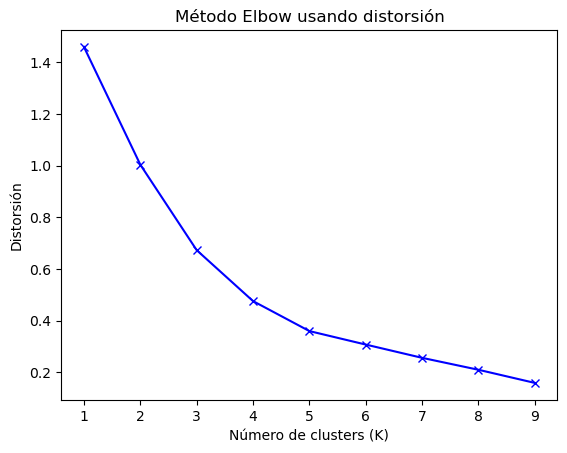

     5. Clusterización utilizando KMeans


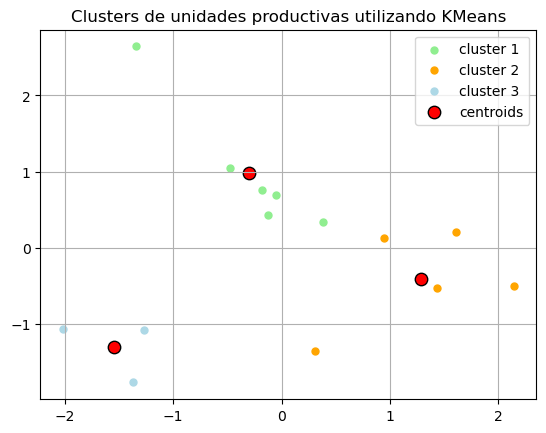

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,PROPIETARIOS_MUJERES_dummy_0,PROPIETARIOS_MUJERES_dummy_1,PROPIETARIOS_HOMBRES_dummy_0,PROPIETARIOS_HOMBRES_dummy_1,R_MERCANTIL_Si y la renovó el último año,RAZON_CREAR_NEGOCIO_Identificó_una_oportunidad_en_e,RAZON_CREAR_NEGOCIO_Las_personas_necesitan_de_mis_p,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_No_tenía_trabajo
kmeans,,,,,,,,,,,,,,,,,,,,,
2,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
0,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
1,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


kmeans                                                                0  \
index                                              mean    11054.333333   
                                                   median   9861.000000   
                                                   std      8128.942555   
EDAD                                               mean       47.733320   
                                                   median     47.599979   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_a... median      0.000000   
                                                   std         0.000000   
RAZON_CREAR_NEGOCIO_No_tenía_trabajo               mean        0.166667   
                                                   median      0.000000   
                                                   std         0.408248   

kmeans                                                                1  \
index                                              mean    17796.000000   
                                                   median  18681.000000   
                                                   std      5733.647094   
EDAD                                               mean       56.240008   
                                                   median     52.200042   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_a... median      0.000000   
                                                   std         0.547723   
RAZON_CREAR_NEGOCIO_No_tenía_trabajo               mean        0.000000   
                                                   median      0.000000   
                                                   std         0.000000   

kmeans                                                                2  
index                                              mean    14603.333333  
                                                   median  17163.000000  
                                                   std     12528.174262  
EDAD                                               mean       54.400006  
                                                   median     52.200018  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_a... median      0.000000  
                                                   std         0.000000  
RAZON_CREAR_NEGOCIO_No_tenía_trabajo               mean        0.000000  
                                                   median      0.000000  
                                                   std         0.000000  

[81 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_Identificó_una_oportunidad_en_e,RAZON_CREAR_NEGOCIO_Las_personas_necesitan_de_mis_p,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Corazon Productivo
index,,,,,,,,,,,,,,,,,,,,,
993,59.000000,4.350000e+07,31.0,Si,De 5 a menos de 10 años,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,2,...,1,0,0,0,0,1.290203,-0.404985,3.374892,17.033987,17.033987
17163,52.200018,4.350000e+07,15.0,Si,De 5 a menos de 10 años,1,0,Si y la renovó el último año,Me_gusta_este_producto_o_servic,2,...,0,0,1,0,0,1.290203,-0.404985,2.984233,27.205546,27.205546
25654,52.000000,4.350000e+07,23.0,Si,10 años o más,1,0,Si y la renovó el último año,Me_gusta_este_producto_o_servic,2,...,0,0,1,0,0,1.290203,-0.404985,2.644328,36.055631,36.055631
1556,42.000000,4.350000e+07,21.0,Si,De 3 a menos de 5 años,0,1,Si y la renovó el último año,Me_gusta_este_producto_o_servic,0,...,0,0,1,0,0,1.290203,-0.404985,1.649874,61.948143,61.948143
4133,52.199958,4.350000e+07,25.0,Si,10 años o más,0,1,Si y la renovó el último año,No_tenía_trabajo,0,...,0,0,0,0,1,1.290203,-0.404985,1.729841,59.866030,59.866030
7483,56.000000,4.350000e+07,11.0,Si,10 años o más,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,1,0,0,0,0,1.290203,-0.404985,1.178528,74.220539,74.220539
12239,41.000000,8.000000e+07,27.0,Si,Menos de un año,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,1,0,0,0,0,1.290203,-0.404985,4.029117,0.000000,0.000000
19658,43.000000,4.350000e+07,25.0,Si,10 años o más,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,1,0,0,0,0,1.290203,-0.404985,2.285535,45.397483,45.397483
21257,52.199964,4.350000e+07,24.0,Si,De 3 a menos de 5 años,0,1,Si y la renovó el último año,Identificó_una_oportunidad_en_e,0,...,1,0,0,0,0,1.290203,-0.404985,1.880629,55.939982,55.939982


Programa: Bogotá Alto Impacto
     1. Tipo de criterio: Excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,15525.000000,1.552500e+04,15525.000000,15525.000000,15525.000000
mean,45.796832,1.741137e+07,4.088757,0.465378,0.558776
std,12.276403,3.981166e+07,16.168001,0.498816,0.496549
min,19.000000,1.014000e+06,1.000000,0.000000,0.000000
25%,37.000000,8.400000e+06,1.000000,0.000000,0.000000
50%,45.794670,1.741137e+07,2.000000,0.000000,1.000000
75%,54.000000,1.741137e+07,4.000000,1.000000,1.000000
max,98.000000,1.850000e+09,1000.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
df_famd


FAMD(random_state=0)

prueba x


270311536478.97745

prueba rc


,0,1
0,-1.223820,0.650895
1,1.136544,1.253211
2,-1.096627,-0.926682
3,-1.245845,-0.697935
4,0.593629,-0.260434
...,...,...
26415,0.121472,0.484894
26416,-1.439391,-0.112722
26417,1.167981,0.730303
26418,-1.067985,0.150595


Distorsión
1 : 1.2752634974682333
2 : 0.7756952955190198
3 : 0.6212523498516377
4 : 0.5043764021216326
5 : 0.43634378350283415
6 : 0.37959753598006707
7 : 0.3504148117763518
8 : 0.3249987974666675
9 : 0.3066535380333305


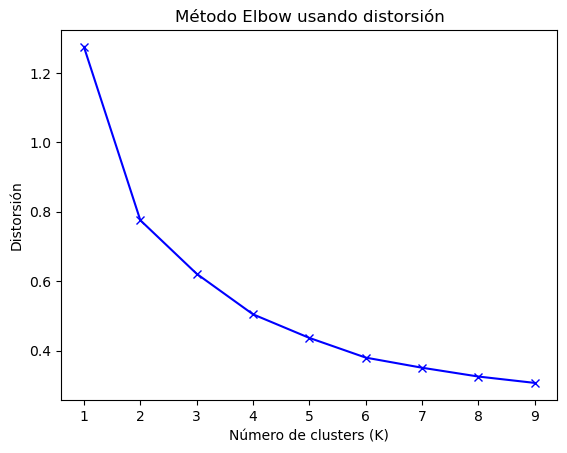

     5. Clusterización utilizando KMeans


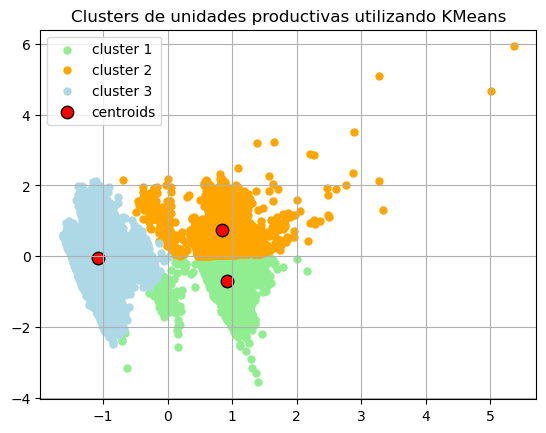

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Me_gusta_este_producto_o_servic,RAZON_CREAR_NEGOCIO_Necesita_generar_ingresos_adici,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan
kmeans,,,,,,,,,,,,,,,,,,,,,
2,6958,6958,6958,6958,6958,6958,6958,6958,6958,6958,...,6958,6958,6958,6958,6958,6958,6958,6958,6958,6958
1,4338,4338,4338,4338,4338,4338,4338,4338,4338,4338,...,4338,4338,4338,4338,4338,4338,4338,4338,4338,4338
0,4229,4229,4229,4229,4229,4229,4229,4229,4229,4229,...,4229,4229,4229,4229,4229,4229,4229,4229,4229,4229


kmeans                                                                0  \
index                                              mean    13141.274060   
                                                   median  12833.000000   
                                                   std      7517.361761   
EDAD                                               mean       53.459399   
                                                   median     53.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.131134   
RAZON_CREAR_NEGOCIO_nan                            mean        0.001892   
                                                   median      0.000000   
                                                   std         0.043458   

kmeans                                                                1  \
index                                              mean    13259.846704   
                                                   median  13412.500000   
                                                   std      7632.540019   
EDAD                                               mean       39.592722   
                                                   median     39.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000   
                                                   std         0.080090   
RAZON_CREAR_NEGOCIO_nan                            mean        0.000692   
                                                   median      0.000000   
                                                   std         0.026292   

kmeans                                                                2  
index                                              mean    13288.453722  
                                                   median  13369.500000  
                                                   std      7636.372178  
EDAD                                               mean       45.007588  
                                                   median     45.701028  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... median      0.000000  
                                                   std         0.123060  
RAZON_CREAR_NEGOCIO_nan                            mean        0.002587  
                                                   median      0.000000  
                                                   std         0.050800  

[108 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_No_tenía_trabajo,RAZON_CREAR_NEGOCIO_Para ocupar mi tiempo,RAZON_CREAR_NEGOCIO_Para_ocupar_mi_tiempo_,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,RAZON_CREAR_NEGOCIO_nan,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Bogotá Alto Impacto
index,,,,,,,,,,,,,,,,,,,,,
0,33.000000,1.741137e+07,2.0,No,De 1 a menos de 3 años,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,2,...,0,0,0,0,0,-1.078256,-0.03946,0.705535,91.982935,91.982935
2,62.000000,6.000000e+06,2.0,No,De 5 a menos de 10 años,1,0,Si y la renovó el último año,Identificó una oportunidad en e,2,...,0,0,0,0,0,-1.078256,-0.03946,0.887412,89.910538,89.910538
3,54.000000,1.741137e+07,2.0,No,De 3 a menos de 5 años,1,0,Si y la renovó el último año,No_tenía_trabajo,2,...,1,0,0,0,0,-1.078256,-0.03946,0.679466,92.279976,92.279976
6,45.000000,2.500000e+06,2.0,Si,De 1 a menos de 3 años,1,0,Si y la renovó el último año,Identificó_una_oportunidad_en_e,2,...,0,0,0,0,0,-1.078256,-0.03946,1.334871,84.811960,84.811960
9,50.000000,1.200000e+06,1.0,No,De 3 a menos de 5 años,1,0,Si y la renovó el último año,No_tenía_trabajo,2,...,1,0,0,0,0,-1.078256,-0.03946,0.606963,93.106116,93.106116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26387,60.000000,1.741137e+07,2.0,No,10 años o más,1,1,Si y la renovó el último año,Por tradición familiar o lo her,0,...,0,0,0,1,0,-1.078256,-0.03946,1.718527,80.440378,80.440378
26397,45.000000,4.000000e+07,3.0,No,De 3 a menos de 5 años,0,1,Si y la renovó el último año,Me_gusta_este_producto_o_servic,0,...,0,0,0,0,0,-1.078256,-0.03946,1.936490,77.956797,77.956797
26402,65.000000,1.741137e+07,3.0,Si,10 años o más,0,1,Si y la renovó el último año,Me_gusta_este_producto_o_servic,0,...,0,0,0,0,0,-1.078256,-0.03946,2.440239,72.216827,72.216827


Programa: Hecho en Bogotá
     1. Tipo de criterio: Excluyente
     2. Estadísticas descriptivas después de imputación MICE


,EDAD,INGRESOS,NO_TRABAJADORES,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy
count,374.000000,3.740000e+02,374.000000,374.000000,374.000000
mean,42.810241,1.425440e+07,3.500000,0.532086,0.596257
std,10.749574,2.621048e+07,6.342228,0.499638,0.491304
min,20.000000,1.100000e+06,1.000000,0.000000,0.000000
25%,35.000000,4.000000e+06,1.000000,0.000000,0.000000
50%,42.460961,1.200000e+07,2.000000,1.000000,1.000000
75%,50.000000,1.425440e+07,3.000000,1.000000,1.000000
max,77.000000,3.500000e+08,99.000000,1.000000,1.000000


     3. Se reduce dimensionalidad utilizando análisis de factores para datos mixtos
     4. Definición número de clusters utilizando el método Elbow
df_famd


FAMD(random_state=0)

prueba x


5331145600.001557

prueba rc


,0,1
125,0.572215,-2.391415
151,-1.039100,0.544999
220,-0.812957,0.776219
234,-1.217821,0.016644
268,-1.514284,-0.685304
...,...,...
26232,1.276687,0.506897
26239,-1.130538,0.484259
26249,0.689182,-2.193699
26315,0.871555,-0.604188


Distorsión
1 : 1.2367278546834801
2 : 0.751466986575064
3 : 0.6749604545972202
4 : 0.5659629630528354
5 : 0.5156789512861769
6 : 0.4787795126304322
7 : 0.4411553743748185
8 : 0.3827793970966765
9 : 0.35253898507795367


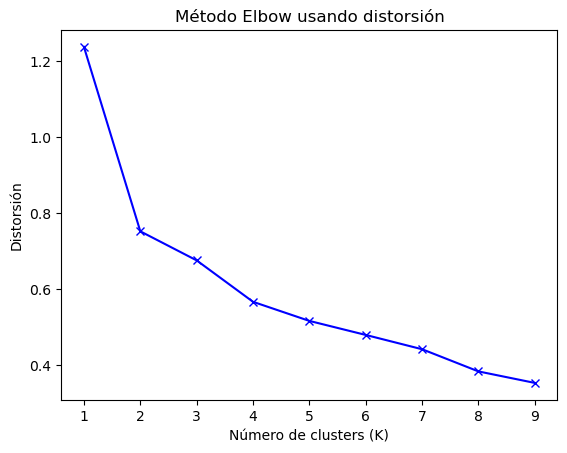

     5. Clusterización utilizando KMeans


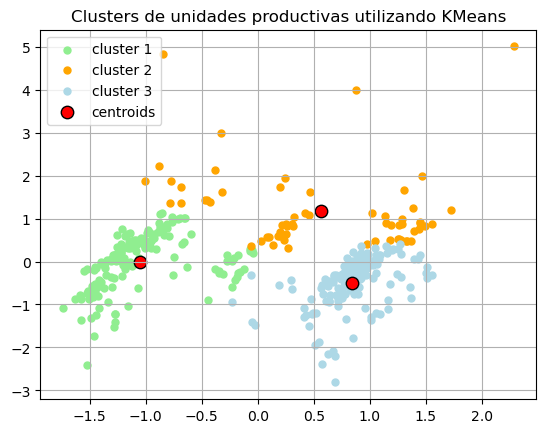

     6. Caracterísiticas de cada cluster


,index,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,...,PROPIETARIOS_HOMBRES_dummy_1,R_MERCANTIL_No,R_MERCANTIL_Si y la renovó el último año,"R_MERCANTIL_Sí, pero desactualizada",RAZON_CREAR_NEGOCIO_Identificó una oportunidad en e,RAZON_CREAR_NEGOCIO_Las personas necesitan de mis p,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her
kmeans,,,,,,,,,,,,,,,,,,,,,
2,152,152,152,152,152,152,152,152,152,152,...,152,152,152,152,152,152,152,152,152,152
0,157,157,157,157,157,157,157,157,157,157,...,157,157,157,157,157,157,157,157,157,157
1,65,65,65,65,65,65,65,65,65,65,...,65,65,65,65,65,65,65,65,65,65


kmeans                                                                0  \
index                                              mean    13542.343949   
                                                   median  15030.000000   
                                                   std      7651.015358   
EDAD                                               mean       39.463239   
                                                   median     38.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_No tenía trabajo               median      0.000000   
                                                   std         0.319618   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... mean        0.044586   
                                                   median      0.000000   
                                                   std         0.207053   

kmeans                                                                1  \
index                                              mean    14039.261538   
                                                   median  15167.000000   
                                                   std      7659.148489   
EDAD                                               mean       53.035639   
                                                   median     52.000000   
...                                                                 ...   
RAZON_CREAR_NEGOCIO_No tenía trabajo               median      0.000000   
                                                   std         0.000000   
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... mean        0.046154   
                                                   median      0.000000   
                                                   std         0.211451   

kmeans                                                                2  
index                                              mean    13279.302632  
                                                   median  12633.500000  
                                                   std      7956.719634  
EDAD                                               mean       41.894639  
                                                   median     41.000000  
...                                                                 ...  
RAZON_CREAR_NEGOCIO_No tenía trabajo               median      0.000000  
                                                   std         0.299223  
RAZON_CREAR_NEGOCIO_Por tradición familiar o lo... mean        0.059211  
                                                   median      0.000000  
                                                   std         0.236799  

[84 rows x 3 columns]

     7. Puntaje de cada unidad productiva según su distancia al centroide del cluster seleccionado


,EDAD,INGRESOS,NO_TRABAJADORES,DIGITAL,ANTIGUEDAD,PROPIETARIOS_MUJERES_dummy,PROPIETARIOS_HOMBRES_dummy,R_MERCANTIL,RAZON_CREAR_NEGOCIO,kmeans,...,RAZON_CREAR_NEGOCIO_Las personas necesitan de mis p,RAZON_CREAR_NEGOCIO_Me gusta este producto o servic,RAZON_CREAR_NEGOCIO_Necesitaba generar ingresos adi,RAZON_CREAR_NEGOCIO_No tenía trabajo,RAZON_CREAR_NEGOCIO_Por tradición familiar o lo her,x_mean_chosen,y_mean_chosen,dist_chosen,min_dist_order,Hecho en Bogotá
index,,,,,,,,,,,,,,,,,,,,,
125,25.000000,2.000000e+06,3.0,Si,De 3 a menos de 5 años,0,1,"Sí, pero desactualizada",Necesitaba generar ingresos adi,2,...,0,0,1,0,0,0.84447,-0.495427,1.915436,66.414839,66.414839
463,36.000000,1.425440e+07,1.0,Si,De 5 a menos de 10 años,0,1,No,Necesitaba generar ingresos adi,2,...,0,0,1,0,0,0.84447,-0.495427,0.543802,90.582568,90.582568
524,52.000000,3.000000e+06,4.0,Si,De 3 a menos de 5 años,1,1,No,No tenía trabajo,2,...,0,0,0,1,0,0.84447,-0.495427,1.160399,79.718336,79.718336
812,42.523036,5.000000e+06,2.0,Si,De 3 a menos de 5 años,0,1,Si y la renovó el último año,Identificó una oportunidad en e,2,...,0,0,0,0,0,0.84447,-0.495427,0.167847,97.206771,97.206771
931,48.000000,2.000000e+06,3.0,Si,De 3 a menos de 5 años,1,1,"Sí, pero desactualizada",Necesitaba generar ingresos adi,2,...,0,0,1,0,0,0.84447,-0.495427,1.304201,77.184605,77.184605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25476,77.000000,1.425440e+07,2.0,Si,10 años o más,0,1,Si y la renovó el último año,Identificó una oportunidad en e,1,...,0,0,0,0,0,0.84447,-0.495427,1.910352,66.504421,66.504421
25781,53.000000,1.500000e+07,2.0,Si,10 años o más,1,1,Si y la renovó el último año,Necesitaba generar ingresos adi,1,...,0,0,1,0,0,0.84447,-0.495427,1.174784,79.464889,79.464889
25957,54.000000,1.425440e+07,6.0,Si,De 5 a menos de 10 años,1,1,Si y la renovó el último año,Necesitaba generar ingresos adi,1,...,0,0,1,0,0,0.84447,-0.495427,1.271916,77.753453,77.753453


In [9]:
for nombre_programa in list_programas:
   x_res = triage.triage(nombre_programa, df_tropa, cp.features, cp.features_cont, 
                 cp.features_cat, mice_imputer, famd)
   df_tropa_contacto = df_tropa_contacto.join(x_res[nombre_programa], lsuffix='_caller', rsuffix='_other')

### Guardar archivo de priorización

Este es el archivo que se le entrega a tropa para segundas visitas.

In [10]:
df_tropa_contacto.to_csv(output_path + 'priorizacion.csv', index = False)

In [11]:
#df_tropa_contacto.to_excel(output_path + 'priorizacion.xlsx', index = False)

In [12]:
df_tropa_contacto

,ObjectID,LOCALIDAD,UPZ,DIRECCION_COMPLETA,COMPLEMENTO,NOMBRE_ENCUESTADO,RAZON_SOCIAL,NOMBRE_COMERCIAL,TELEFONOS,CORREOS,...,NUMERO_ID_PROPIETARIO,TIPO_ID_NEGOCIO,NUMERO_ID_NEGOCIO,Agencia Pública de Empleo,Pago por resultados o Empleo Joven,Bogotá Productiva Local,Camino a la inclusión financiera,Corazon Productivo,Bogotá Alto Impacto,Hecho en Bogotá
0,51748,Barrios_Unidos,Doce_De_Octubre,DIRECCION_COMPLETA_51748,COMPLEMENTO_51748,NOMBRE_ENCUESTADO_51748,RAZON_SOCIAL_51748,NOMBRE_COMERCIAL_51748,TELEFONOS_51748,CORREOS_51748,...,NUMERO_ID_PROPIETARIO_51748,Cédula_de_Ciudadanía,NUMERO_ID_NEGOCIO_51748,NaN,NaN,81.842091,NaN,NaN,91.982935,NaN
1,55818,Puente_Aranda,San_Rafael,DIRECCION_COMPLETA_55818,COMPLEMENTO_55818,NOMBRE_ENCUESTADO_55818,RAZON_SOCIAL_55818,NOMBRE_COMERCIAL_55818,TELEFONOS_55818,CORREOS_55818,...,NUMERO_ID_PROPIETARIO_55818,NIT_número_de_identificación_tr,NUMERO_ID_NEGOCIO_55818,NaN,NaN,NaN,NaN,NaN,70.801648,NaN
2,147857,San Cristóbal,La Gloria,DIRECCION_COMPLETA_147857,COMPLEMENTO_147857,NOMBRE_ENCUESTADO_147857,RAZON_SOCIAL_147857,NOMBRE_COMERCIAL_147857,TELEFONOS_147857,CORREOS_147857,...,NUMERO_ID_PROPIETARIO_147857,Cédula de Ciudadanía,NUMERO_ID_NEGOCIO_147857,NaN,NaN,84.240149,NaN,NaN,89.910538,NaN
3,111455,Bosa,Tintal_Sur,DIRECCION_COMPLETA_111455,COMPLEMENTO_111455,NOMBRE_ENCUESTADO_111455,RAZON_SOCIAL_111455,NOMBRE_COMERCIAL_111455,TELEFONOS_111455,CORREOS_111455,...,NUMERO_ID_PROPIETARIO_111455,Cédula_de_Ciudadanía,NUMERO_ID_NEGOCIO_111455,NaN,NaN,83.556439,NaN,NaN,92.279976,NaN
4,44352,Los_Mártires,La_Sabana,DIRECCION_COMPLETA_44352,COMPLEMENTO_44352,NOMBRE_ENCUESTADO_44352,RAZON_SOCIAL_44352,NOMBRE_COMERCIAL_44352,TELEFONOS_44352,CORREOS_44352,...,NUMERO_ID_PROPIETARIO_44352,NIT_número_de_identificación_tr,NUMERO_ID_NEGOCIO_44352,NaN,NaN,98.149995,NaN,NaN,80.806174,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26415,122975,Bosa,Bosa Central,DIRECCION_COMPLETA_122975,COMPLEMENTO_122975,NOMBRE_ENCUESTADO_122975,RAZON_SOCIAL_122975,NOMBRE_COMERCIAL_122975,TELEFONOS_122975,CORREOS_122975,...,NUMERO_ID_PROPIETARIO_122975,NIT (número de identificación t,NUMERO_ID_NEGOCIO_122975,NaN,NaN,76.789855,84.413427,NaN,85.103204,NaN
26416,57712,Puente_Aranda,San_Rafael,DIRECCION_COMPLETA_57712,COMPLEMENTO_57712,NOMBRE_ENCUESTADO_57712,RAZON_SOCIAL_57712,NOMBRE_COMERCIAL_57712,TELEFONOS_57712,CORREOS_57712,...,NUMERO_ID_PROPIETARIO_57712,Cédula_de_Ciudadanía,NUMERO_ID_NEGOCIO_57712,NaN,NaN,81.249281,NaN,NaN,95.823386,NaN
26417,17412,Santa_Fe,Las_Nieves,DIRECCION_COMPLETA_17412,COMPLEMENTO_17412,NOMBRE_ENCUESTADO_17412,RAZON_SOCIAL_17412,NOMBRE_COMERCIAL_17412,TELEFONOS_17412,CORREOS_17412,...,NUMERO_ID_PROPIETARIO_17412,Cédula_de_Ciudadanía,NUMERO_ID_NEGOCIO_17412,NaN,NaN,86.139550,NaN,NaN,72.966209,NaN
26418,57593,Barrios_Unidos,Los_Andes,DIRECCION_COMPLETA_57593,COMPLEMENTO_57593,NOMBRE_ENCUESTADO_57593,RAZON_SOCIAL_57593,NOMBRE_COMERCIAL_57593,TELEFONOS_57593,CORREOS_57593,...,NUMERO_ID_PROPIETARIO_57593,NIT_número_de_identificación_tr,NUMERO_ID_NEGOCIO_57593,NaN,NaN,81.879678,NaN,NaN,97.853418,NaN
